# Bulge / Total exploration

This notebook reads in files created elsewhere containing galaxy builder models (aggregate, best individual and optimized best individual) and compares the Bulge / Total fraction to results in the literature

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
from gzbuilder_analysis.rendering.sersic import _b
import gzbuilder_analysis.fitting as fitting
from gzbuilder_analysis.fitting.jupyter import UpdatableDisplay
from IPython.display import HTML

Could not find some files, some functions may not work


Read in the required files:

In [3]:
sid_list = np.loadtxt('lib/subject-id-list.csv', dtype='u8')

# catalogues to compare to
simard_df = pd.read_csv('lib/simard-catalog_fixed-n.csv', index_col=0)
simard_df_free = pd.read_csv('lib/simard-catalog_free-n.csv', index_col=0)
lackner_nb1 = pd.read_csv('lib/lackner_nb1.csv', index_col=0)
lackner_nb4 = pd.read_csv('lib/lackner_nb4.csv', index_col=0)

# GZB results
aggregation_results = pd.read_pickle('lib/aggregation_results.pickle')
best_models = pd.read_pickle('lib/best_individual.pickle')
fitted_models = pd.read_pickle('lib/fitted_models.pickle')

In [4]:
catalog_results = pd.concat((
  simard_df[['__B_T_r', 'e__B_T_r']]
    .rename(columns=dict(__B_T_r='Sbt', e__B_T_r='eSbt')),
  simard_df_free[['__B_T_r', 'e__B_T_r']]
    .rename(columns=dict(__B_T_r='Sbt_free', e__B_T_r='eSbt_free')),
  lackner_nb1[['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']]
    .rename(columns=dict(BULGE_TO_TOT_R='Lbt1', BULGE_TO_TOT_R_ERR='eLbt1')),
  lackner_nb4[['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']]
    .rename(columns=dict(BULGE_TO_TOT_R='Lbt4', BULGE_TO_TOT_R_ERR='eLbt4')),
), axis=1)

display_column_map = dict(
  Sbt='Exponential + De Vaucoulers\n(Simard, 2011)',
  Sbt_free='Exponential + Sersic\n(Simard, 2011)',
  Lbt1='Exponential + Exponential\n(Lackner, 2012)',
  Lbt4='Exponential + De Vaucoulers\n(Lackner, 2012)',
)
catalog_results.describe()

,Sbt,eSbt,Sbt_free,eSbt_free,Lbt1,eLbt1,Lbt4,eLbt4
count,296.000000,296.000000,294.000000,294.000000,224.000000,224.000000,224.000000,224.000000
mean,0.157466,0.008885,0.292483,0.018061,0.108795,5923.105743,0.174067,0.023354
std,0.130613,0.010501,0.261888,0.031242,0.126834,51927.107199,0.174276,0.048144
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000298,0.000000,0.000713
25%,0.060000,0.000000,0.090000,0.000000,0.038871,0.001090,0.045580,0.002937
50%,0.120000,0.010000,0.195000,0.010000,0.065596,0.002073,0.115510,0.007436
75%,0.220000,0.010000,0.420000,0.020000,0.127879,0.004652,0.256837,0.021660
max,0.680000,0.110000,1.000000,0.230000,0.894223,545087.000000,0.901284,0.326977


What is the relationship between measured bulge to total fraction in our different catalogues? Does it vary with the best model type calculated by Lackner & Gunn (2012) (Pure 1-component Sersic or Exponential, or either an Exponential or Pseudo-Bulge)?

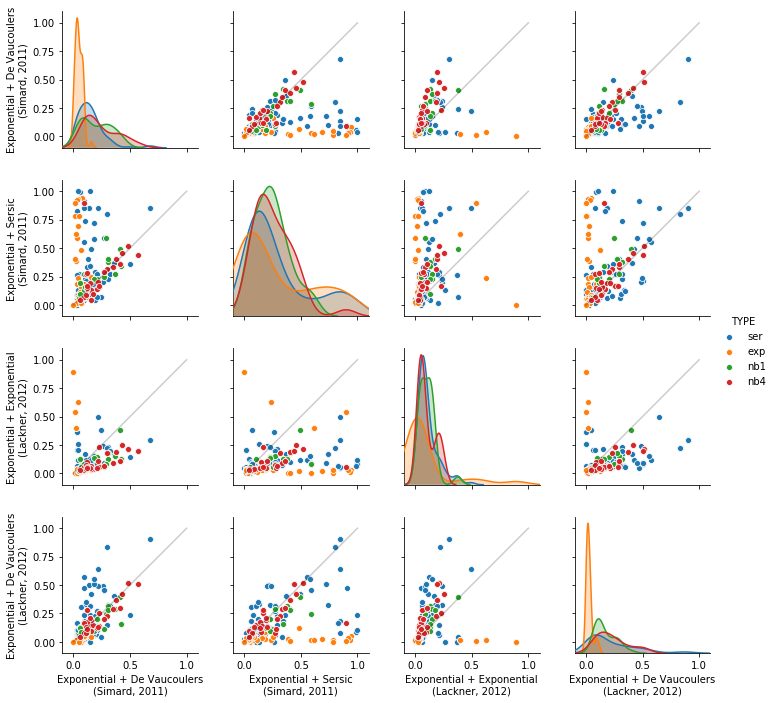

In [5]:
_df = pd.concat((
  catalog_results[['Sbt', 'Sbt_free', 'Lbt1', 'Lbt4']],
  lackner_nb1.query('TYPE != "dvc"')['TYPE'],
), axis=1).dropna()

g = sns.pairplot(
  _df.rename(columns=display_column_map),
  hue='TYPE',
)
offdiag = (ax for i, axs in enumerate(g.axes) for j, ax in enumerate(axs) if i != j)
for ax in offdiag:
  ax.add_line(plt.Line2D((0, 1), (0, 1), c='k', alpha=0.2))
  ax.set_xlim(-0.1, 1.1)
  ax.set_ylim(-0.1, 1.1)

Even when comparing the same model being fit by different surveys, we see a lot of scatter (though a notable 1:1 relationship). When Sérsic index for the bulge is fixed to 1, there is next to no agreement with other models, while a 

## Galaxy Builder measurements

We'll now introduce Galaxy Builder measurements into the mix!

First, initalise rendering Model objects for all the different kinds of model

In [6]:
def make_model(subject_id, m):
  psf = gu.get_psf(subject_id)
  diff_data = gu.get_diff_data(subject_id)
  pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
  galaxy_data = np.array(diff_data['imageData'])[::-1]
  return fitting.Model(m, galaxy_data, psf=psf, pixel_mask=pixel_mask)

In [7]:
bi_models = pd.Series([]).rename('best_individual')
with tqdm(
  best_models['Model'].dropna().items(),
  total=len(best_models),
  desc='{: <25}'.format('Best individual')
) as bar:
  for i, model in bar:
    bi_models[i] = make_model(i, model)
      
tuned_bi_models = pd.Series([]).rename('tuned_best_individual')
with tqdm(
  fitted_models['bi'].dropna().items(),
  total=len(fitted_models['bi'].dropna()),
  desc='{: <25}'.format('Fitted best individual')
) as bar:
  for i, model in bar:
    tuned_bi_models[i] = make_model(i, model)

tuned_agg_models = pd.Series([]).rename('tuned_aggregate')
with tqdm(
  fitted_models['agg'].dropna().items(),
  total=len(fitted_models['agg'].dropna()),
  desc='{: <25}'.format('Aggregate')
) as bar:
  for i, model in bar:
    tuned_agg_models[i] = make_model(i, model)

Aggregate                : 100%|██████████| 256/256 [01:24<00:00,  3.04it/s]


In [8]:
names = ('Best Individual', 'Tuned Best Individual', 'Tuned Aggregate')

What is the distribution of Bulge Sérsic index for our models?

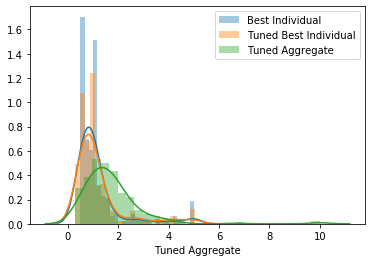

In [9]:
def get_bulge_arg(m, param='n'):
  return m['bulge'].get(param, np.nan) if m['bulge'] is not None else np.nan

for models, name in zip(
  (best_models['Model'], fitted_models['bi'], fitted_models['agg']),
  names,
):
  sns.distplot(
    models
      .dropna()
      .apply(get_bulge_arg, param='n')
      .dropna()
      .rename(name),
    label=name
  )
plt.legend();

Interestingly, volunteers preferred much lower Sérsic indices than other fitting toolkits. As explored separately, this is probably to do with the allowed parameter space (dictated by the sliders and their precision) being too restricive to allow the large effective radii and low $\Sigma_e$s associated with higher Sérsic index bulges.

We would expect Galaxy Builder results to agree best with the Lackner & Gunn (2012) Exponential + Exponential model.

In [10]:
def get_measures(model):
  model_flux = model.cached_render(model._model).sum()
  gal_flux = model.data.sum() * 0.8
  bulge_flux = model.cache[1].sum()
  bar_flux = model.cache[2].sum()
  loss = fitting.loss(
    model.cached_render(model._model),
    model.data,
    model.pixel_mask
  )
  return pd.Series(dict(
    model_flux=model_flux,
    gal_flux=gal_flux,
    bulge_flux=bulge_flux,
    bar_flux=bar_flux,
    loss=loss,
    bt=(bulge_flux + bar_flux) / model_flux
  ))

In [11]:
tqdm.pandas(desc='Calculating {: <25}'.format(names[0]))
bi_measures = bi_models.progress_apply(get_measures)
tqdm.pandas(desc='Calculating {: <25}'.format(names[1]))
tuned_measures = tuned_bi_models.progress_apply(get_measures)
tqdm.pandas(desc='Calculating {: <25}'.format(names[2]))
tuned_agg_measures = tuned_agg_models.progress_apply(get_measures)

Calculating Tuned Aggregate          : 100%|██████████| 256/256 [00:06<00:00, 38.03it/s]


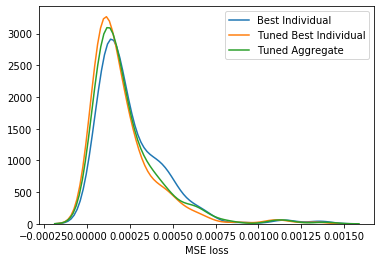

In [12]:
for i, measure in enumerate((bi_measures, tuned_measures, tuned_agg_measures)):
  sns.kdeplot(measure.loss.dropna().rename(names[i]))
plt.xlabel('MSE loss');

## Results

Make Series of bulge/total and bar/total ratios

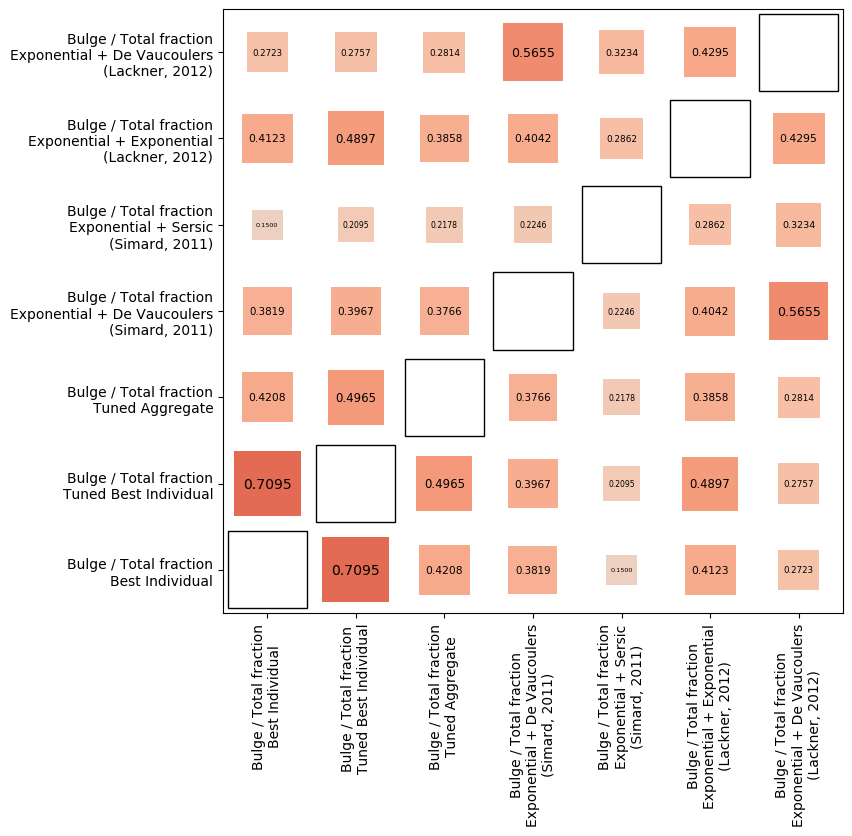

In [13]:
_df2 = pd.concat((
  bi_measures['bt'].rename(names[0]),
  tuned_measures['bt'].rename(names[1]),
  tuned_agg_measures['bt'].rename(names[2]),
  catalog_results[display_column_map.keys()].rename(columns=display_column_map),
), axis=1)
plt.figure(figsize=(8, 8), dpi=100)
correlation = _df2.corr(method='kendall').values
scale = 0.8
for i in range(correlation.shape[0]):
  for j in range(correlation.shape[1]):
    if i == j:
      fc = 'none'
      ec = 'k'
    else:
      fc = plt.cm.coolwarm((correlation[i, j] + 1) / 2)
      ec = 'none'
    rect_size = np.sqrt(correlation[i, j] * scale)
    centre = i - rect_size / 2, j - rect_size/2
    s = plt.Rectangle(
      centre, width=rect_size, height=rect_size,
      fc=fc, ec=ec
    )
    plt.gca().add_patch(s)
    if i != j:
      t = plt.text(
        i, j,
        '{:.4f}'.format(correlation[i, j]),
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12 * np.sqrt(correlation[i, j])
      )
cols = ['Bulge / Total fraction\n' + i for i in _df2.columns]
plt.xticks(np.arange(7), cols, rotation=90)
plt.xlim(-0.5, 6.5)
plt.yticks(np.arange(7), cols)
plt.ylim(-0.5, 6.5)
plt.savefig('method-paper-plots/b-t_comparison_correlation.pdf', bbox_inches='tight');

We see that Galaxy Builder results correlate as well with other catalogues as the catalogues with each other (when not comparing identical models). But this tells us nothing of whether this correlation is 1:1 - for that we need to look at the point scatter:

As the Exp + Sersic model was all over the place, we ignore it in the following plot

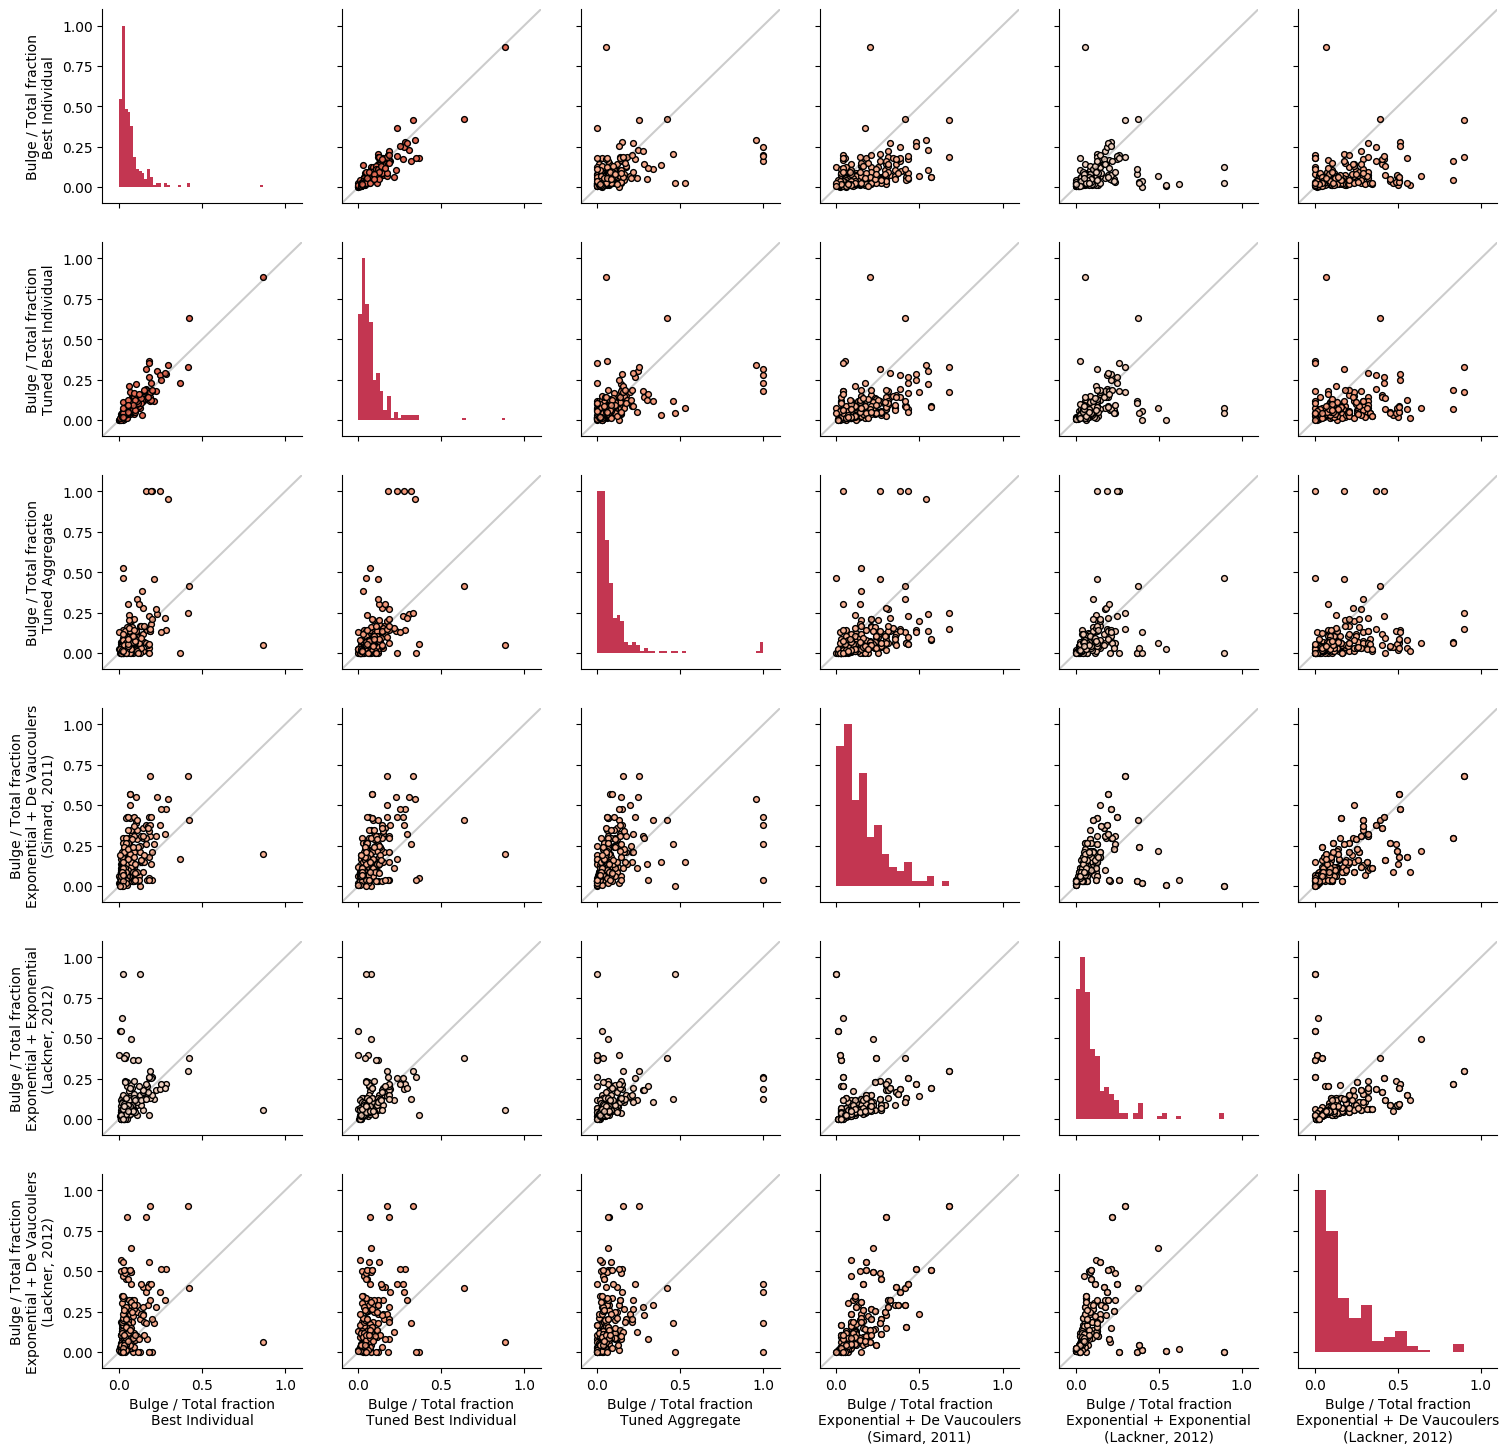

In [14]:
cols = _df2.columns[[0, 1, 2, 3, 5, 6]]

marker_kws = dict(s=17.5, edgecolors='k')
f, axs = plt.subplots(ncols=len(cols), nrows=len(cols), figsize=(18, 18), dpi=100, sharex=True, sharey=True)
for i in range(len(cols)):
  for j in range(len(cols)):
    fc = np.array(plt.cm.coolwarm((correlation[i, j] + 1) / 2))
    if i == j:
      hist, edges = np.histogram(_df2[cols[i]].dropna(), density=True, bins='auto')
      for k in range(len(edges) - 1):
        axs[i][j].add_patch(
          plt.Rectangle(
            (edges[k], 0),
            width=edges[k+1] - edges[k],
            height=hist[k] / hist.max(),
            fc=fc,
            alpha=0.8,
          )
        )
    else:
      _d = _df2[cols[[i, j]]].dropna()
      axs[i][j].scatter(_d[cols[j]], _d[cols[i]], c=fc[np.newaxis, :], **marker_kws)
      axs[i][j].add_line(plt.Line2D((-1.5, 1.5), (-1.5, 1.5), c='k', alpha=0.2))
    axs[i][j].set_xlim(-0.1, 1.1)
    axs[i][j].set_ylim(-0.1, 1.1)
    if j == 0:
      axs[i][j].set_ylabel('Bulge / Total fraction\n' + cols[i])
    if i == len(cols) - 1:
      axs[i][j].set_xlabel('Bulge / Total fraction\n' + cols[j])
sns.despine()
plt.savefig('method-paper-plots/b-t_comparison_scatter.pdf', bbox_inches='tight');

We see that there is only really a 1:1 relationship between galaxy builder results and the Lackner & Gunn (2012) Exponential + Exponential model, suggesting that the bias present in Galaxy Builder Bulge Sérsic indices plays a huge part in the calculation of Bulge / Total ratio.

We see similar relationships when comparing between different bulge + disk models (i.e. exp + exp to exp + dv) as we do when comparing the more complex galaxy builder models, suggesting that it is the bulge sersic index which is causing the systematic difference.

# Sersic n degeneracy

People couldn't really use high sersic indices in galaxy builder. What does this mean for the B/T ratio? If we find the best n=4 bulge for each of our volunteer-dictated bulges, in what way is the bulge/total ratio changed?

In [15]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [16]:
def compare_bulges(p, n, model, target):
  conv_bulge = model._psf_convolve(
    model._render_component(
      'bulge',
      dict(bulge={**model['bulge'], **dict(rEff=p[0], i0=p[1], n=n)}),
    )
  )
  return mean_squared_error(target.ravel(), conv_bulge.ravel())


def best_dv_bulge(sid, model):
  target = model._psf_convolve(model._render_component('bulge', dict(bulge=model['bulge'])))
  if target.sum() == 0:
    return np.nan, np.nan, np.nan, np.nan
  p0 = (model['bulge']['rEff'], model['bulge']['i0'])
  res = minimize(
    compare_bulges, p0, args=(4, model, target), bounds=((1E-10, np.inf), (1E-10, np.inf))
  )
  if res['success']:
    p = res['x']
    new_bulge = {**model['bulge'], **dict(rEff=p[0], i0=p[1], n=4)}
    conv_bulge = model.render(dict(disk=None, bulge=new_bulge, bar=None, spiral=[]))
    n4_flux = conv_bulge.sum()
    old_flux = target.sum()
    return n4_flux, old_flux, new_bulge, res['fun']

n4_bulges_df = pd.DataFrame([], columns=('flux_diff', 'new_bulge', 'score'))
with tqdm(bi_models.items(), total=len(bi_models)) as bar:
  for i, m in bar:
    if m['bulge'] is not None:
      n4_flux, old_flux, new_bulge, score = best_dv_bulge(i, m)
      n4_bulges_df.loc[i] = pd.Series(dict(
        flux_diff=n4_flux / old_flux,
        new_flux=n4_flux,
        old_flux=old_flux,
        new_bulge=new_bulge,
        score=score,
      ))

100%|██████████| 296/296 [06:55<00:00,  1.12it/s]


What do the relative changes in flux look like?

1.1059516892179084


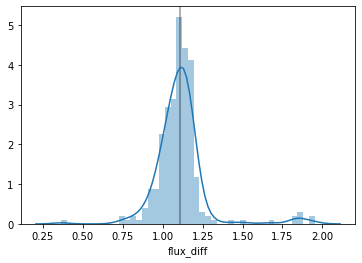

In [17]:
sns.distplot(n4_bulges_df.flux_diff.dropna())
l = plt.ylim() 
median = n4_bulges_df.flux_diff.median()
plt.vlines(median, 0, l[1], alpha=0.4)
plt.ylim(*l)
print(median)

What happens if we alter the measured Bulge / Total scatter by these values?

Exponential + De Vaucoulers
(Simard, 2011) Best Individual


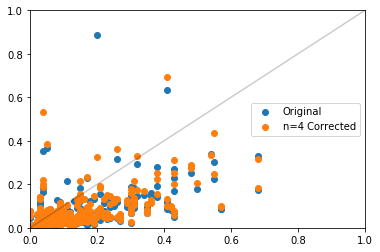

In [18]:
print(_df2.columns[3], _df2.columns[0])
plt.scatter(_df2[_df2.columns[3]], _df2[_df2.columns[1]], label='Original')
plt.scatter(_df2[_df2.columns[3]], _df2[_df2.columns[1]] * n4_bulges_df.flux_diff, label='n=4 Corrected')
plt.gca().add_line(plt.Line2D((0, 1), (0, 1), c='k', alpha=0.2))
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1);

We see only a small difference, though it's worth noting that the fit earlier is highly dependant on initial conditions, and this kind of attempt at correcting things is no substitute for removing biases in the first place, or performing a full fit.